In [1]:
from src.data import *

dataset = process_raw_data(year_start=2017)
dataset, binner = create_features(dataset)

raw ds shape: (322, 8)
dropping -185 duplicates
dropping 14 rows for 2017 year start
processed ds shape: (124, 6)


In [2]:
dataset.head()

,headline,claps,site_id,year,month,site,binned-class,log-claps,clip-claps,n-characters,n-words
0,the deepest reason why modern javascript frame...,11700.0,dailyjs,2018,03,dailyjs,3.0,9.367344,11700.0,57,8
1,data visualization with react-vis,1200.0,dailyjs,2018,03,dailyjs,2.0,7.090077,1200.0,33,4
2,tips & tricks for vue-analytics,1400.0,dailyjs,2018,03,dailyjs,2.0,7.244228,1400.0,31,5
3,lean react project with parcel,584.0,dailyjs,2018,03,dailyjs,1.0,6.369901,584.0,30,5
4,stay updated in js fatigue universe,558.0,dailyjs,2018,03,dailyjs,1.0,6.324359,558.0,35,6


In [3]:
grps = dataset.groupby('site_id').mean().loc[:, 'claps'].to_frame()
grps = grps.to_dict()['claps']
dataset.loc[:, 'site_id'].replace(grps)

0      1479.935484
1      1479.935484
2      1479.935484
3      1479.935484
4      1479.935484
5      1479.935484
21     1479.935484
22     1479.935484
23     1479.935484
24     1479.935484
25     1479.935484
26     1479.935484
27     1479.935484
28     1479.935484
29     1479.935484
30     1479.935484
36     1479.935484
37     1479.935484
38     1479.935484
39     1479.935484
40     1479.935484
41     1479.935484
58     1479.935484
59     1479.935484
60     1479.935484
61     1479.935484
62     1479.935484
63     1479.935484
64     1479.935484
66     1479.935484
67     1479.935484
68     1479.935484
69     1479.935484
70     1479.935484
71     1479.935484
72     1479.935484
73     1479.935484
74     1479.935484
85     1479.935484
86     1479.935484
87     1479.935484
88     1479.935484
89     1479.935484
90     1479.935484
91     1479.935484
93     1479.935484
94     1479.935484
95     1479.935484
96     1479.935484
102    1479.935484
103    1479.935484
104    1479.935484
110    1479.

In [4]:
dataset.sort_values('claps', ascending=False)

,headline,claps,site_id,year,month,site,binned-class,log-claps,clip-claps,n-characters,n-words
37,when do i know im ready for redux?,14600.0,dailyjs,2017,10,dailyjs,3.0,9.588777,14600.0,34,8
0,the deepest reason why modern javascript frame...,11700.0,dailyjs,2018,03,dailyjs,3.0,9.367344,11700.0,57,8
111,understanding v8s bytecode,9100.0,dailyjs,2017,08,dailyjs,3.0,9.116030,9100.0,26,3
25,7 hacks for es6 developers,8700.0,dailyjs,2017,12,dailyjs,3.0,9.071078,8700.0,26,5
160,threads in node 10.5.0: a practical intro,6500.0,dailyjs,2018,06,dailyjs,3.0,8.779557,6500.0,41,7
68,how to use javascript proxies for fun and profit,5300.0,dailyjs,2018,01,dailyjs,3.0,8.575462,5300.0,48,9
85,a simple guide to understanding javascript (es...,5300.0,dailyjs,2018,05,dailyjs,3.0,8.575462,5300.0,59,8
184,"react is slow, react is fast: optimizing react...",4800.0,dailyjs,2017,02,dailyjs,3.0,8.476371,4800.0,63,11
267,put your electron app on a diet with electrino,4400.0,dailyjs,2017,01,dailyjs,3.0,8.389360,4400.0,46,9
141,how to prevent your node.js process from crashing,4400.0,dailyjs,2018,02,dailyjs,3.0,8.389360,4400.0,49,8


## Clap statistics

In [5]:
dataset['claps'].describe()

count      124.000000
mean      1479.935484
std       2195.646616
min         38.000000
25%        340.500000
50%        712.000000
75%       1600.000000
max      14600.000000
Name: claps, dtype: float64

## Distribution of claps

<AxesSubplot:ylabel='Frequency'>

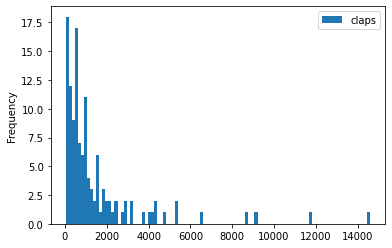

In [6]:
dataset.plot(y='claps', kind='hist', bins=100)

## Distribution of clipped claps

<AxesSubplot:ylabel='Frequency'>

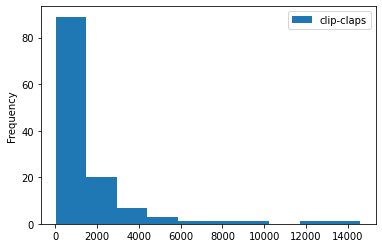

In [7]:
dataset.plot(y='clip-claps', kind='hist')

## Distribution of log claps

<AxesSubplot:ylabel='Frequency'>

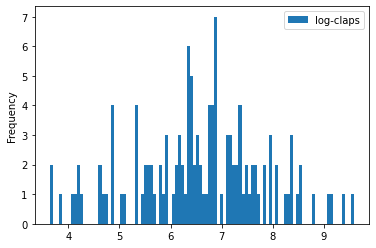

In [8]:
dataset.plot(y='log-claps', kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

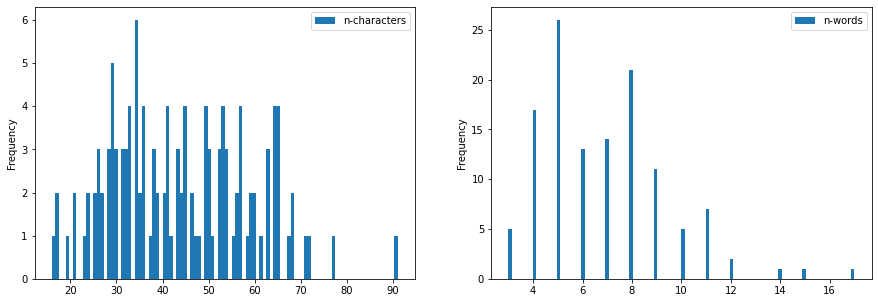

In [9]:
f, axes = plt.subplots(ncols=2, figsize=(15, 5))
dataset.plot(ax=axes[0], y='n-characters', kind='hist', bins=100)
dataset.plot(ax=axes[1], y='n-words', kind='hist', bins=100)

## Binning the claps

In [10]:
target = dataset.groupby('binned-class').count().loc[:, 'headline']
target

binned-class
0.0    31
1.0    31
2.0    29
3.0    33
Name: headline, dtype: int64

<AxesSubplot:xlabel='binned-class'>

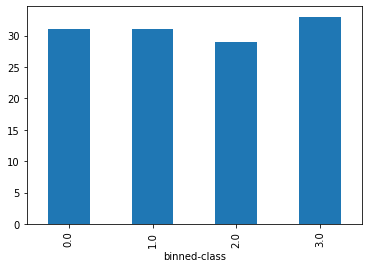

In [11]:
target.plot(kind='bar')

## How do claps change over time?

In [12]:
years = dataset.groupby('year').agg({'claps': ['median', 'mean']})
years.columns = years.columns.get_level_values(1)
years

,median,mean
year,,
2017,703.0,1394.013158
2018,895.0,1615.979167


<AxesSubplot:xlabel='year'>

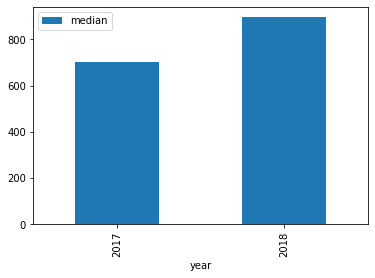

In [13]:
years.plot(kind='bar', y='median')

## By site

In [14]:
sites = dataset.groupby('site_id').agg({'claps': ['median', 'mean', 'count']})
sites.columns = sites.columns.get_level_values(1)
sites.sort_values('median')

,median,mean,count
site_id,,,
dailyjs,712.0,1479.935484,124


## By site and year

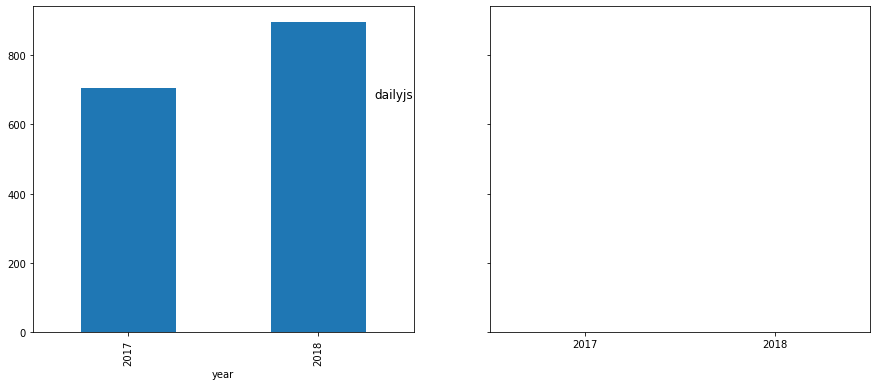

In [15]:
from math import ceil

sites = list(set(dataset['site_id']))
f, axes = plt.subplots(ncols=2, nrows=ceil(len(sites) / 2), sharex=True, sharey=True, figsize=(15, 6))

for site, ax in zip(sites, axes.flatten()):
    mask = dataset.loc[:, 'site_id'] == site
    subset = dataset.loc[mask, :]
    grp = subset.groupby('year').agg({'claps': 'median'})
    grp.plot(ax=ax, kind='bar')
    ax.get_legend().remove()
    ax.set_title(site, loc='right', y=0.7)

## Headline features

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vec = CountVectorizer()
x = vec.fit_transform(dataset['headline'])
x = x.todense()
print(x.shape)

(124, 432)


In [17]:
names = np.array(vec.get_feature_names())
counts = np.squeeze(np.array(x.sum(axis=0)))

In [18]:
counts[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
sort_idx = np.squeeze(np.array(counts.argsort()))

In [20]:
counts[sort_idx][-32:]

array([ 4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
        7,  8,  9, 10, 10, 12, 13, 18, 18, 21, 22, 29, 29, 30, 31])

In [21]:
names[sort_idx][-32:]

array(['based', 'google', 'building', 'why', 'you', 'started', 'api',
       'state', 'getting', 'app', 'casl', 'vue', 'es6', 'async', 'node',
       'build', 'using', 'use', 'native', 'your', 'of', 'for', 'redux',
       'js', 'how', 'the', 'in', 'javascript', 'with', 'to', 'react',
       'and'], dtype='<U14')